In [2]:

from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)

import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())
    
    
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [3]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


In [4]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [8]:
features

['39',
 ' State-gov',
 ' 77516',
 ' Bachelors',
 ' 13',
 ' Never-married',
 ' Adm-clerical',
 ' Not-in-family',
 ' White',
 ' Male',
 ' 2174',
 ' 0',
 ' 40',
 ' United-States']

In [7]:
categorical_columns

['39',
 ' State-gov',
 ' Bachelors',
 ' 13',
 ' Never-married',
 ' Adm-clerical',
 ' Not-in-family',
 ' White',
 ' Male',
 ' 2174',
 ' 0',
 ' 40',
 ' United-States',
 ' <=50K',
 'Set']

In [5]:
cat_idxs

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [6]:
cat_dims

[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]

In [10]:
from pytorch_tabnet.pretraining import TabNetPretrainer

# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)


max_epochs = 100 if not os.getenv("CI", False) else 2 # 1000

/usr/local/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [11]:
unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
) 

epoch 0  | loss: 6.37668 | val_0_unsup_loss_numpy: 2.2052900791168213|  0:00:00s
epoch 5  | loss: 1.05857 | val_0_unsup_loss_numpy: 1.0304800271987915|  0:00:04s
epoch 10 | loss: 0.95327 | val_0_unsup_loss_numpy: 0.8934800028800964|  0:00:07s
epoch 15 | loss: 0.8705  | val_0_unsup_loss_numpy: 0.8123700022697449|  0:00:11s
epoch 20 | loss: 0.79963 | val_0_unsup_loss_numpy: 0.7097399830818176|  0:00:15s
epoch 25 | loss: 0.69462 | val_0_unsup_loss_numpy: 0.6313599944114685|  0:00:18s
epoch 30 | loss: 0.67904 | val_0_unsup_loss_numpy: 0.6129599809646606|  0:00:22s
epoch 35 | loss: 0.65613 | val_0_unsup_loss_numpy: 0.5874599814414978|  0:00:25s
epoch 40 | loss: 0.63078 | val_0_unsup_loss_numpy: 0.5667399764060974|  0:00:29s
epoch 45 | loss: 0.59874 | val_0_unsup_loss_numpy: 0.530460000038147|  0:00:33s
epoch 50 | loss: 0.57078 | val_0_unsup_loss_numpy: 0.4933899939060211|  0:00:36s
epoch 55 | loss: 0.53744 | val_0_unsup_loss_numpy: 0.45034000277519226|  0:00:40s
epoch 60 | loss: 0.51074 | v

/usr/local/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


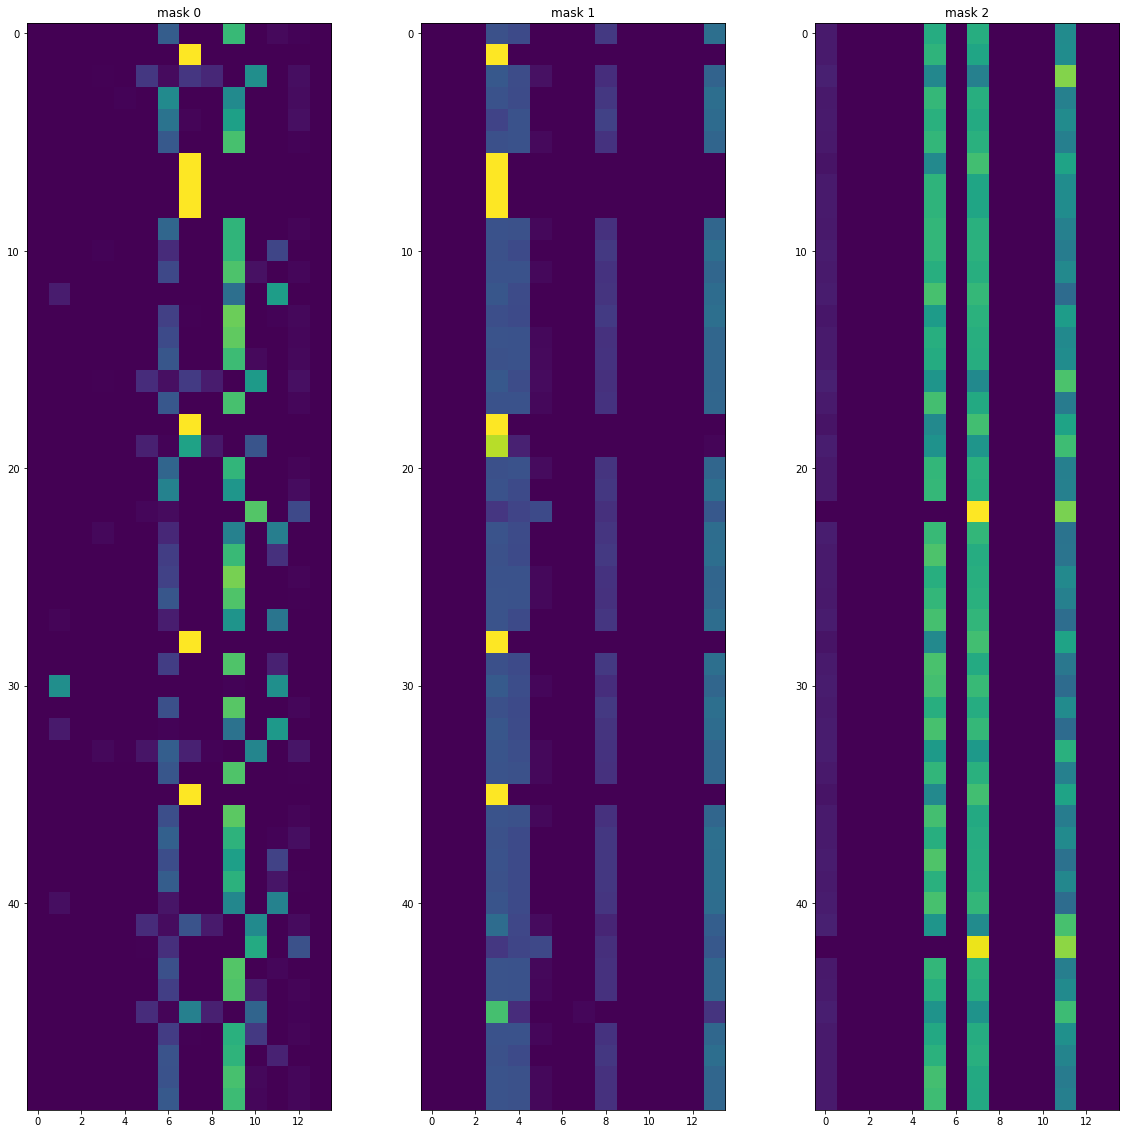

In [12]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape==embedded_X.shape)

unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)


fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [15]:
unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

Successfully saved model at ./test_pretrain.zip


/usr/local/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [16]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-3),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax', # This will be overwritten if using pretrain model
                       verbose=5,
                      )

/usr/local/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [17]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain,
    
) 

/usr/local/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: cat_dims changed from [] to [73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]
  warnings.warn(wrn_msg)
/usr/local/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/usr/local/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  warnings.warn(wrn_msg)
/usr/local/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/usr/local/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 2.19459 | train_auc: 0.26203 | valid_auc: 0.23823 |  0:00:00s
epoch 5  | loss: 0.43755 | train_auc: 0.87691 | valid_auc: 0.87843 |  0:00:05s
epoch 10 | loss: 0.38519 | train_auc: 0.91141 | valid_auc: 0.91385 |  0:00:10s
epoch 15 | loss: 0.36663 | train_auc: 0.91956 | valid_auc: 0.91897 |  0:00:15s
epoch 20 | loss: 0.35766 | train_auc: 0.92616 | valid_auc: 0.92357 |  0:00:20s
epoch 25 | loss: 0.34574 | train_auc: 0.92863 | valid_auc: 0.92636 |  0:00:25s
epoch 30 | loss: 0.33634 | train_auc: 0.93275 | valid_auc: 0.92992 |  0:00:30s
epoch 35 | loss: 0.33404 | train_auc: 0.93151 | valid_auc: 0.92826 |  0:00:34s
epoch 40 | loss: 0.32412 | train_auc: 0.93413 | valid_auc: 0.9315  |  0:00:39s
epoch 45 | loss: 0.32894 | train_auc: 0.93499 | valid_auc: 0.93146 |  0:00:44s
epoch 50 | loss: 0.32593 | train_auc: 0.93546 | valid_auc: 0.93119 |  0:00:49s
epoch 55 | loss: 0.32957 | train_auc: 0.93552 | valid_auc: 0.93064 |  0:00:54s
epoch 60 | loss: 0.32316 | train_auc: 0.93628 | vali

/usr/local/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


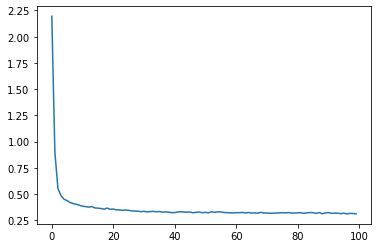

In [19]:
# plot losses
plt.plot(clf.history['loss'])

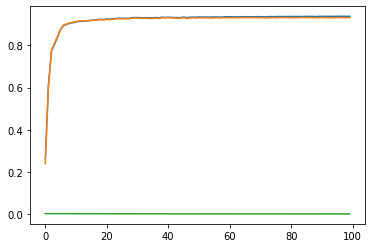

In [20]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

# plot learning rates
plt.plot(clf.history['lr'])

In [18]:
#Predictions
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")



# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

BEST VALID SCORE FOR census-income : 0.9325119809413004
FINAL TEST SCORE FOR census-income : 0.9308647148704793


In [21]:
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)


loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

assert(test_auc == loaded_test_auc)

Successfully saved model at ./tabnet_model_test_1.zip
FINAL TEST SCORE FOR census-income : 0.9308647148704793


/usr/local/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [22]:
clf.feature_importances_

array([1.14445213e-04, 1.44981320e-02, 4.56911023e-03, 6.93205059e-02,
       5.71602262e-02, 9.57990708e-02, 2.03913207e-01, 1.06269901e-01,
       5.12364022e-02, 1.03070989e-01, 7.34402616e-02, 8.70895078e-02,
       4.46506690e-02, 8.88675717e-02])

In [23]:
explain_matrix, masks = clf.explain(X_test)

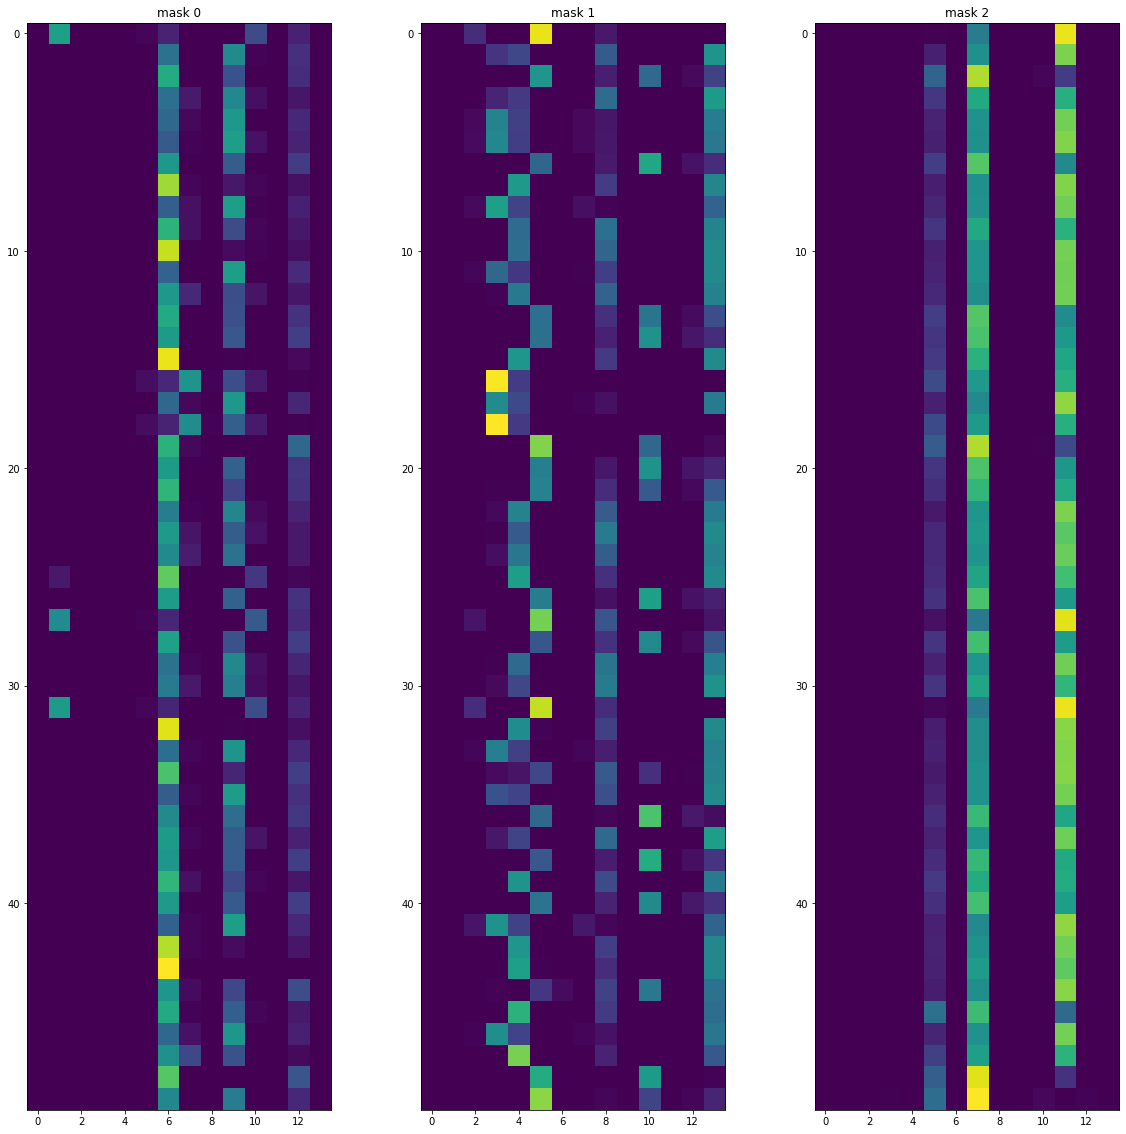

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")